**Machine Learning for Time Series (Master MVA)**

- TP1, Thursday 17<sup>th</sup> October 2024
- [Link to the class material.](http://www.laurentoudre.fr/ast.html)

# Introduction

In this notebook, we illustrate two concepts:
- convolutional dictionary learning (CDL),
- dynamic time warping (DTW).

## Setup

**Import**

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from dtw import dtw
from IPython.display import Audio, display
from loadmydata.load_uea_ucr import load_uea_ucr_data
from matplotlib.colors import rgb2hex
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist, squareform
from scipy.signal.windows import tukey

from alphacsc import learn_d_z
try:
    from alphacsc.utils import construct_X
except:
    from alphacsc.utils.convolution import construct_X

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



ImportError: cannot import name 'tukey' from 'scipy.signal' (/opt/anaconda3/lib/python3.12/site-packages/scipy/signal/__init__.py)

**Utility functions**

In [2]:
def plot_CDL(signal, Z, D, figsize=(15, 10)):
    """Plot the learned dictionary `D` and the associated sparse codes `Z`.

    `signal` is an univariate signal of shape (n_samples,) or (n_samples, 1).
    """
    (atom_length, n_atoms) = np.shape(D)
    plt.figure(figsize=figsize)
    plt.subplot(n_atoms + 1, 3, (2, 3))
    plt.plot(signal)
    for i in range(n_atoms):
        plt.subplot(n_atoms + 1, 3, 3 * i + 4)
        plt.plot(D[:, i])
        plt.subplot(n_atoms + 1, 3, (3 * i + 5, 3 * i + 6))
        plt.plot(Z[:, i])
        plt.ylim((np.min(Z), np.max(Z)))

In [3]:
def display_distance_matrix_as_table(
    distance_matrix, labels=None, figsize=(8, 2)
):
    fig, ax = plt.subplots(figsize=figsize)
    ax.axis("tight")
    ax.axis("off")
    norm = mpl.colors.Normalize()
    cell_colours_hex = np.empty(shape=distance_matrix.shape, dtype=object)
    cell_colours_rgba = plt.get_cmap("magma")(norm(distance_matrix))

    for i in range(distance_matrix.shape[0]):
        for j in range(i + 1, distance_matrix.shape[0]):
            cell_colours_hex[i, j] = rgb2hex(
                cell_colours_rgba[i, j], keep_alpha=True
            )
            cell_colours_hex[j, i] = cell_colours_hex[i, j]

    if labels is not None:
        _ = ax.table(
            cellText=distance_matrix,
            colLabels=labels,
            rowLabels=labels,
            loc="center",
            cellColours=cell_colours_hex,
        )
    else:
        _ = ax.table(
            cellText=distance_matrix,
            loc="center",
            cellColours=cell_colours_hex,
        )

    return ax

In [4]:
def get_n_largest(
    arr: np.ndarray, n_largest: int = 3
) -> (np.ndarray, np.ndarray):
    """Return the n largest values and associated indexes of an array.

    (In decreasing order of value.)
    """
    indexes = np.argsort(arr)[-n_largest:][::-1]
    if n_largest == 1:
        indexes = np.array(indexes)
    values = np.take(arr, indexes)
    return values, indexes

In [5]:
def fig_ax(figsize=(15, 5)):
    return plt.subplots(figsize=figsize)

# Convolutional dictionary learning (CDL)

## Data

Task is to classify the nature of the heartbeat signal.

Heart sound recordings were sourced from several contributors around the world, collected at either a clinical or nonclinical environment, from both healthy subjects and pathological patients.
Each series represent the aplitude of the singal over time.

Heart sound recordings were sourced from several contributors around the world, collected at either a clinical or nonclinical environment, from both healthy subjects and pathological patients.
The heart sound recordings were collected from different locations on the body. The typical four locations are aortic area, pulmonic area, tricuspid area and mitral area, but could be one of nine different locations.
The sounds were divided into two classes: normal and abnormal. The normal recordings were from healthy subjects and the abnormal ones were from patients with a confirmed cardiac diagnosis.
The patients suffer from a variety of illnesses, but typically they are heart valve defects and coronary artery disease patients.
Heart valve defects include mitral valve prolapse, mitral regurgitation, aortic stenosis and valvular surgery. All the recordings from the patients were generally labeled as abnormal.
Both healthy subjects and pathological patients include both children and adults.

Data was recorded at 2,000Hz.
Data was truncated to the shortest instance.

Original data can be found here:
https://www.physionet.org/physiobank/database/challenge/2016/

Original paper:
Goldberger AL, Amaral LA, Glass L, Hausdorff JM, Ivanov PC, Mark RG, Mietus JE, Moody GB, Peng CK, Stanley HE. PhysioBank, PhysioToolkit, and PhysioNet: components of a new research resource for complex physiologic signals. circulation. 2000 Jun 13;101(23):e215-20.

Correspondence should be addressed to Ary L. Goldberger:
ary@astro.bidmc.harvard.edu

Instances: 409

Time series length: 18,530

Classes:
- Normal (110)
- Abnormal (299)


Données de son de battements cardiaques. 

Le but de la tâche est de classifier la nature des signaux cardiaques (normal, anormal)

- Chaque série représente l'amplitude du signal dans le temps.

- Données ont été enregistrées à une fréquence de 2 000 Hz (1 secondes -> 2000 observations)

In [6]:
# fmt: off
X_train = np.loadtxt("BinaryHeartbeat.csv").reshape((204, 18530, 1))
y_train = np.array(['Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Abnormal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal'])
# fmt: on

In [11]:
X_train.shape

(204, 18530, 1)

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>What is the sampling frequency of those sounds?</p>
</div>

In [7]:
FREQUENCY = 2000  # Hz

We can plot a signal from each class (normal and abnormal).

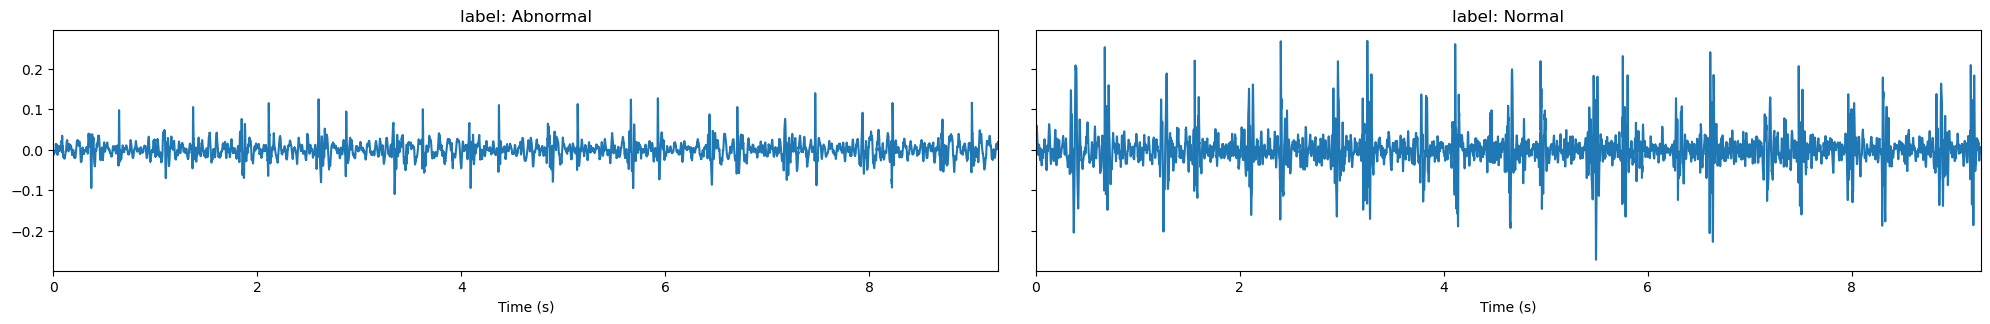

In [8]:
fig, ax_arr = plt.subplots(nrows=1, ncols=2, figsize=(20, 3), sharey=True)
fig.tight_layout()
for ind, ax in zip([1, 200], ax_arr):
    s = X_train[ind]
    tt = np.arange(s.size) / FREQUENCY
    ax.plot(tt, s)
    ax.set_xlim(0, s.size / FREQUENCY)
    ax.set_xlabel("Time (s)")
    _ = ax.set_title(f"label: {y_train[ind]}")

In [9]:
# Since the time series are sound signals, we can choose one and listen to it.

for ind in [1, 200]:
    signal = X_train[ind]
    label = y_train[ind]
    print(label)
    display(Audio(signal.flatten(), rate=FREQUENCY))

Abnormal


Normal


For the subsequent study, we select only 6 elements (3 from each classe) from the complete data set.

In [12]:
sub_sample = [0, 1, 2, 190, 191, 192]  # 3 Normal, 3 Abnormal
X = np.take(
    X_train, sub_sample, axis=0
).squeeze()  # shape (n_series, n_samples)
y = np.take(y_train, sub_sample, axis=0)  # shape (n_series,)

# normalize signals (zero mean, unit variance).
X -= X.mean(axis=1).reshape(-1, 1)
X /= X.std(axis=1).reshape(-1, 1)

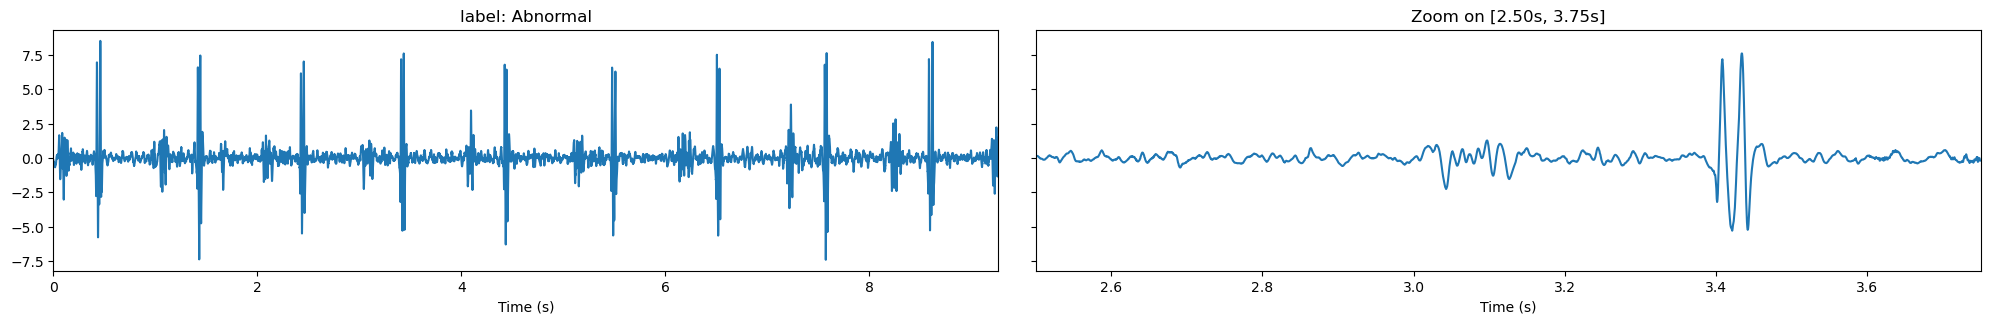

In [13]:
ind = 2
signal = X[ind]
label = y[ind]

fig, ax_arr = plt.subplots(nrows=1, ncols=2, figsize=(20, 3), sharey=True)
fig.tight_layout()
ax = ax_arr[0]

n_samples = signal.size
tt = np.arange(n_samples) / FREQUENCY
ax.plot(tt, signal)
ax.set_xlabel("Time (s)")
ax.set_xlim(0, n_samples / FREQUENCY)

ax.set_title(f"label: {label}")

ax = ax_arr[1]
start, end = 5000, 7500  # change here to zoom somewhere else
ax.plot(tt[start:end], signal[start:end])
ax.set_xlim(tt[start], tt[end])
ax.set_xlabel("Time (s)")
_ = ax.set_title(f"Zoom on [{start/FREQUENCY:.2f}s, {end/FREQUENCY:.2f}s]")

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Roughly, what is the duration of the important phenomenon (the heartbeat)?</p>
</div>

Environ 0.5 sec

## CDL on a single signal

For a 1D signal $\mathbf{x}\in\mathbb{R}^N$ with $N$ samples, the convolutional dictionary learning tasks amounts to solving the following optimization problem:

$$
\min_{(\mathbf{d}_k)_k, (\mathbf{z}_k)_k \\ \lVert\mathbf{d}_k\rVert^2\leq 1} \quad (1/2)\left\lVert \mathbf{x} - \sum_{k=1}^K \mathbf{z}_k * \mathbf{d}_k \right\rVert^2 \quad + \quad\lambda \sum_{k=1}^K \lVert\mathbf{z}_k\rVert_1
$$

where $\mathbf{d}_k\in\mathbb{R}^L$ are the $K$ dictionary atoms (patterns), $\mathbf{z}_k\in\mathbb{R}^{N-L+1}$ are activations signals, and $\lambda>0$ is the sparsity constraint.

This problem is not convex with respect to the couple $(\mathbf{d}_k)_k, (\mathbf{z}_k)_k$ but convex when the subproblems are taken individually.

- Les z sont des signaux d'activation que l'on veut sparse (d'où la régularisation) : 0 si pas de battement cardiaque et qqc sinon

- Les d sont des atomes, petits

--> Optimisation alternée (on fixe les z et on optimise sur d et inversement)

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>What are the parameters that a user must calibrate when using CDL?</p>
</div>

Les trois paramètres que l'on doit choisir sont (input) : 

- Pénalité 

- Nombre d'atomes

- La longueur des atomes 

Sortie : dictionnaire et les activations 

We can now apply CDL on a single signal.

In [14]:
# Select a signal
signal = X[2]
data = signal[np.newaxis, :]  # shape (1, n_samples)

In [15]:
# Parameters to change
n_atoms = 3  # K
atom_length = 2000  # L
penalty = 3  # lambda

In [16]:
# learning a dictionary and codes
pobj, _, d_hat, z_hat, _ = learn_d_z(
    X=data,
    n_atoms=n_atoms,
    n_times_atom=atom_length,
    reg=penalty,
    n_iter=30,
    n_jobs=3,
    verbose=1)

NameError: name 'learn_d_z' is not defined

In [ ]:
# plot the results
plot_CDL(signal, z_hat.T.squeeze(), d_hat.T.squeeze())

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>How does the number of activation evolve when the sparsity penalty changes?</p>
</div>

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Looking at the sparse codes, can you tell:</p>
    <ul>    
    <li>How many times each atom is activated?</li>
    <li>What is the compression rate (number of non-zero coefficients in the sparse codes / signal length)?</li>
    </ul>
</div>

In [ ]:
...

Listen to the learned dictionary.

In [ ]:
for k, atom in enumerate(d_hat):
    print(f"Atom {k}")
    display(Audio(atom, rate=FREQUENCY))

Now, let us look at the reconstruction error.

In [ ]:
# Reconstruction with the dictionary and the sparse codes
reconstruction = construct_X(z_hat, d_hat).squeeze()

fig, ax = fig_ax()
tt = np.arange(signal.shape[0])
ax.plot(tt, signal, label="original", alpha=0.5)
ax.plot(tt, reconstruction, label="reconstructed")

ax.set_title(f"Reconstruction MSE: {np.mean((signal - reconstruction)**2):.2e}")

_ = plt.legend()

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>How does reconstruction error evolve when the sparsity penalty changes?</p>
</div>

In [ ]:
fig, ax_arr = plt.subplots(
    nrows=n_atoms // 3 + 1,
    ncols=3,
    figsize=(20, 4 * (n_atoms // 3 + 1)),
    sharey=True,
)

for k in range(n_atoms):
    ax = ax_arr.flatten()[k]
    reconstruted_with_one_atom = construct_X(
        z_hat[k, np.newaxis, :, :], d_hat[k, np.newaxis, :]
    ).squeeze()
    ax.plot(range(start, end), signal[start:end])
    ax.plot(
        range(start, end),
        reconstruted_with_one_atom[start:end],
    )
    ax.set_title(f"Atom {k} only")

ax = ax_arr.flatten()[n_atoms]
ax.plot(range(start, end), signal[start:end])
ax.plot(
    range(start, end),
    reconstruction[start:end],
)
_ = ax.set_title(f"All atoms")

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Rerun the dictionary learning and sparse coding. What do you observe on the motif shape? And the reconstruction error?</p>
</div>

## CDL on the whole data set

In this section, we apply CDL on the whole data set.

In [20]:
# In the following, we fix the number of atoms and their length
n_atoms = 5
atom_length = 1500
penalty = 4

Dictionary learning.

In [ ]:
pobj, _, d_hat, z_hat, _ = learn_d_z(
    X=X,
    n_atoms=n_atoms,
    n_times_atom=atom_length,
    reg=penalty,
    verbose=1,
    n_jobs=3,
    n_iter=30,
)

Let us plot each of the learned atoms.

In [ ]:
fig, ax_arr = plt.subplots(
    nrows=n_atoms // 3 + 1,
    ncols=3,
    figsize=(20, 4 * (n_atoms // 3 + 1)),
    sharey=True,
)

for k, (atom, ax) in enumerate(zip(d_hat, ax_arr.flatten())):
    ax.plot(atom)
    ax.set_xlim(0, atom.size)
    ax.set_title(f"Atom {k}")

For each signal of the data set, we compute the number of non-zeros activations and the reconstruction error.

In [ ]:
for k, (label, signal) in enumerate(zip(y, X)):
    codes = z_hat[:, k, :]
    reconstruction = construct_X(codes[:, np.newaxis, :], d_hat).squeeze()
    error = np.mean((signal - reconstruction) ** 2)
    nnz_activations = (codes > 1e-3).sum()

    # select the used atoms
    most_used_atoms_activations, most_used_atoms_indexes = get_n_largest(
        (codes > 1e-3).sum(axis=1), n_largest=1
    )
    most_used_atom_msg = ", ".join(
        f"{ind} ({acti*100/nnz_activations:.1f}%)"
        for (acti, ind) in zip(
            most_used_atoms_activations, most_used_atoms_indexes
        )
    )
    print(
        f"Label: {label}, MSE: {error:.2f}, non-zero activations: {nnz_activations}, most used atoms: {most_used_atom_msg}"
    )

Using the `Audio` function, we can listen to the learned dictionary and the reconstructed signals.

In [ ]:
for k, (label, signal) in enumerate(zip(y, X)):
    codes = z_hat[:, k, :]
    reconstruction = construct_X(codes[:, np.newaxis, :], d_hat).squeeze()

    print(label)
    print("\tOriginal", end=" ")
    display(Audio(signal.flatten(), rate=FREQUENCY))
    print("\tReconstruction", end=" ")
    display(Audio(reconstruction, rate=FREQUENCY))

The noise has been removed. For the worst approximated signal, some hearbeats have been skipped.

# Distance between signals (DTW)

## Data


FiftyWords is a data set of word outlines taken from the George
Washington library by T. Rath and used in the paper "Word image
matching using dynamic time warping", CVPR 2003.

Each case is a word. A series is formed by taking the height
profile of the word.

![image](alexandria.png)

Here, we only deal with the top profile (in red).

In [26]:
# fmt: off
profiles = np.loadtxt("dtw_X_train.csv").reshape((450, 270, 1))
labels = np.array(['9', '18', '1', '5', '4', '3', '25', '3', '48', '1', '12', '12', '47', '42', '31', '3', '7', '17', '12', '14', '1', '1', '8', '11', '1', '4', '6', '29', '13', '2', '6', '3', '1', '3', '13', '18', '13', '9', '5', '44', '2', '30', '3', '2', '8', '2', '9', '4', '9', '13', '5', '13', '2', '6', '39', '2', '10', '8', '2', '8', '30', '48', '4', '29', '10', '44', '5', '36', '19', '22', '32', '1', '7', '15', '2', '10', '3', '18', '3', '35', '39', '19', '3', '4', '10', '3', '12', '6', '40', '1', '39', '8', '19', '38', '1', '38', '1', '20', '7', '37', '9', '38', '30', '3', '37', '22', '16', '3', '27', '17', '28', '26', '21', '4', '4', '6', '18', '6', '30', '3', '14', '7', '35', '12', '21', '3', '4', '2', '17', '10', '49', '45', '3', '37', '36', '28', '8', '11', '7', '5', '47', '17', '1', '4', '2', '48', '12', '11', '9', '22', '25', '9', '32', '50', '47', '1', '44', '35', '17', '24', '18', '7', '1', '14', '8', '31', '30', '16', '5', '32', '11', '1', '3', '2', '3', '5', '13', '14', '12', '2', '46', '36', '6', '45', '2', '7', '7', '2', '3', '2', '1', '14', '2', '1', '2', '23', '6', '19', '23', '50', '1', '10', '7', '1', '2', '12', '13', '2', '36', '2', '12', '3', '1', '14', '1', '3', '45', '10', '2', '11', '2', '28', '21', '2', '1', '3', '3', '44', '2', '1', '7', '4', '17', '5', '3', '48', '35', '12', '1', '1', '14', '8', '16', '43', '21', '23', '1', '2', '42', '33', '27', '1', '2', '26', '2', '1', '15', '32', '2', '2', '20', '22', '18', '46', '5', '9', '47', '2', '18', '32', '2', '41', '34', '29', '45', '31', '14', '46', '21', '1', '1', '13', '37', '1', '1', '18', '4', '40', '2', '27', '19', '20', '7', '38', '20', '26', '43', '2', '17', '2', '32', '40', '10', '19', '44', '16', '19', '15', '2', '4', '24', '33', '3', '16', '4', '33', '6', '33', '1', '11', '43', '4', '3', '13', '4', '19', '2', '7', '1', '12', '20', '3', '1', '1', '2', '11', '4', '36', '7', '1', '35', '1', '19', '30', '1', '15', '5', '1', '6', '2', '6', '48', '10', '49', '28', '29', '23', '2', '2', '37', '6', '2', '1', '6', '11', '4', '6', '1', '26', '40', '34', '28', '6', '20', '39', '10', '2', '15', '1', '13', '5', '7', '2', '3', '12', '1', '13', '3', '9', '43', '16', '8', '4', '3', '33', '24', '3', '26', '1', '5', '1', '26', '21', '12', '23', '3', '32', '28', '46', '2', '20', '27', '34', '11', '13', '1', '9', '21', '2', '8', '1', '8', '2', '1', '36', '44', '15', '3', '13', '2', '23', '1', '9', '1', '7', '4', '7', '13', '35', '11', '22', '24', '1', '2', '1', '4', '15', '2', '5', '3'])
# fmt: on

# normalize signals (zero mean, unit variance).
profiles -= profiles.mean(axis=1).reshape(-1, 1, 1)
profiles /= profiles.std(axis=1).reshape(-1, 1, 1)

In [ ]:
word_1, label_1 = profiles[0].flatten(), labels[0]
word_2, label_2 = profiles[1].flatten(), labels[1]
fig, ax = fig_ax()
ax.plot(word_1, label=label_1)
ax.plot(word_2, label=label_2)
_ = plt.legend()

## DTW between two signals

In [ ]:
alignment = dtw(word_1, word_2, keep_internals=True)
fig, ax = fig_ax()
ax.plot(word_1, label=label_1)
ax.plot(word_2, label=label_2)
plt.title(f"DTW: {alignment.distance:.2f}")
_ = plt.legend()

In [ ]:
alignment.plot(type="threeway")

In [ ]:
alignment.plot(type="twoway", offset=10)

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Write a function  which computes the DTW distance between two signals: <tt>get_dtw_distance(signal_1: np.ndarray, signal_2: np.ndarray)->float</tt>.</p>
</div>

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Choose a word and plot the most similar and the most dissimilar, according to the DTW. In addition, print the associated labels.</p>
</div>

## Clustering with DTW

### Clustering a small subset

Out of the whole data set, let us choose 6 word profiles from 2 classes.

In [31]:
# select a few profiles with two different classes
keep_mask = np.isin(labels, ["31", "34"])
labels_sub = labels[keep_mask]
profiles_sub = profiles[keep_mask]
# reorder by label
order_indexes = labels_sub.argsort()
labels_sub = labels_sub[order_indexes]
profiles_sub = profiles_sub[order_indexes]

Compute the distance matrix $D$ of this smaller data set: $D_{ij} = d(x_i, x_j)$.

In [ ]:
# init
distance_matrix = np.zeros(
    (profiles_sub.shape[0], profiles_sub.shape[0]), dtype=float
)

for row in range(profiles_sub.shape[0]):
    for col in range(row + 1, profiles_sub.shape[0]):
        distance_matrix[row, col] = get_dtw_distance(
            profiles_sub[row], profiles_sub[col]
        )
        distance_matrix[col, row] = distance_matrix[row, col]

In [ ]:
_ = display_distance_matrix_as_table(
    np.round(distance_matrix, 2), labels=labels_sub
)

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Create the same plot (distance matrix) with the Euclidean distance instead of the DTW. What do you observe?</p>
</div>

### Clustering on a larger subset

Using the DTW, we can cluster a large set of data (43 words).

In [ ]:
# select a few profiles with two different classes
keep_mask = np.isin(labels, ["4", "6", "14"])
profiles_sub = profiles[keep_mask]
labels_sub = labels[keep_mask]

Compute the distance matrix with the DTW.

In [ ]:
# Instead of the previous double for loop, we can use scipy function pdist
distance_matrix = pdist(
    profiles_sub.squeeze(), metric=get_dtw_distance
)  # condensed distance matrix
# Compute linkage matrix using the 'Ward' criterion
linkage = hierarchy.ward(distance_matrix)

Plot the linkage as a dendogram.

In [ ]:
fig, ax = fig_ax((20, 10))

cut_threshold = 100

dendro = hierarchy.dendrogram(
    linkage,
    ax=ax,
    labels=labels_sub,
    color_threshold=cut_threshold,
    distance_sort=True,
)
ax.axhline(cut_threshold, ls="--", color="k")

In [ ]:
plt.imshow(squareform(distance_matrix))

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Do the same clustering with the Euclidean distance instead. Plot the linkage as a dendogram.</p>
</div>

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>In the previous dendrograms, change the <tt>cut_threshold</tt> argument to have homogeneous clusters (as much as possible).</p>
</div>